In [2]:
# Data Source: https://www.alphavantage.co
# API Key: EVMRD162IRCITXSI

In [3]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Download stock historical data and visualize it
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.techindicators import TechIndicators
ts = TimeSeries(key='EVMRD162IRCITXSI',output_format='pandas')
fd=FundamentalData(key='EVMRD162IRCITXSI',output_format='pandas')
TI=TechIndicators(key='EVMRD162IRCITXSI',output_format='pandas')
# Get json object with the intraday data and another with  the call's metadata

In [5]:
# Download stock historical data
stock_data,stock_meta_data=ts.get_daily_adjusted('AAPL',outputsize='full')

In [6]:
# Download stock technical indicators
ema_data,ema_matadata=TI.get_ema('AAPL', interval='daily', time_period=100, series_type='close')
macd_data,macd_matadata=TI.get_macd('AAPL', interval='daily', series_type='close')
stoch_data,stock_matadata=TI.get_stoch('AAPL', interval='daily')
rsi_data,rsi_matadata=TI.get_rsi('AAPL', interval='daily', time_period=100)
obv_data,obv_matadata=TI.get_obv('AAPL', interval='daily')

In [7]:
# Using the most recent five year historical stock price data for analysis

stock_price = stock_data[stock_data.index > '2000-03-24']['5. adjusted close']
ema_recent = ema_data[ema_data.index > '2000-03-24']['EMA']
macd_recent = macd_data[macd_data.index > '2000-03-24']['MACD_Signal']
obv_recent = obv_data[obv_data.index > '2000-03-24']['OBV']
rsi_recent = rsi_data[rsi_data.index > '2000-03-24']['RSI']

In [8]:
stock_price.to_frame().join(ema_recent).join(macd_recent).join(obv_recent).join(rsi_recent)

,5. adjusted close,EMA,MACD_Signal,OBV,RSI
date,,,,,
2021-02-05,136.760000,122.9412,2.3679,9.522452e+10,56.7492
2021-02-04,137.184364,122.6620,2.4510,9.530021e+10,56.8724
2021-02-03,133.739528,122.3686,2.5456,9.521603e+10,56.1067
2021-02-02,134.787956,122.1389,2.6702,9.530591e+10,56.4085
2021-02-01,133.939228,121.8834,2.7539,9.522364e+10,56.2198
...,...,...,...,...,...
2000-03-31,1.044346,0.8413,0.0412,9.575069e+09,57.3353
2000-03-30,0.966987,0.8372,0.0416,9.170435e+09,56.1663
2000-03-29,1.045345,0.8346,0.0418,9.584835e+09,57.7532


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import os
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

In [10]:
#组合为矩阵，与数据归一化
ema=np.array(ema_recent).reshape(len(ema_recent),1)
macd=np.array(macd_recent).reshape(len(ema_recent),1)
obv=np.array(obv_recent).reshape(len(ema_recent),1)
rsi=np.array(rsi_recent).reshape(len(ema_recent),1)
sp=np.array(stock_price).reshape(len(ema_recent),1)
scaler=MinMaxScaler()
ema=scaler.fit_transform(ema)
macd=scaler.fit_transform(macd)
obv=scaler.fit_transform(obv)
rsi=scaler.fit_transform(rsi)
sp=scaler.fit_transform(sp)
data_jihe=np.hstack([ema,macd,obv,rsi,sp])

In [11]:
#归一化数据

dataset=data_jihe.reshape(-1,5)
# scaler = MinMaxScaler()
# dataset = scaler.fit_transform(dataset)

train_size=int(len(dataset)*0.65)
train_list=dataset[:train_size]
test_list=dataset[train_size-1:]

#确定训练集和测试集
def create_dateset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-6):
        a=dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back:i+look_back+6,1])
    return np.array(dataX),np.array(dataY)

look_back=6
trainX,trainY=create_dateset(train_list, look_back)
testX,testY=create_dateset(test_list, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 5))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1] ,5))

#神经网络设定
model=Sequential()
model.add(LSTM(50,input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(50))
          
model.add(Dense(6))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX,trainY,epochs=200,batch_size=32,verbose=2)
model.save(os.path.join('Data','Test'+'.h5'))

#预测
trainPredict=model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/200
107/107 - 13s - loss: 0.0191
Epoch 2/200
107/107 - 2s - loss: 0.0036
Epoch 3/200
107/107 - 2s - loss: 0.0024
Epoch 4/200
107/107 - 2s - loss: 0.0023
Epoch 5/200
107/107 - 2s - loss: 0.0020
Epoch 6/200
107/107 - 2s - loss: 0.0019
Epoch 7/200
107/107 - 2s - loss: 0.0019
Epoch 8/200
107/107 - 2s - loss: 0.0018
Epoch 9/200
107/107 - 2s - loss: 0.0017
Epoch 10/200
107/107 - 2s - loss: 0.0017
Epoch 11/200
107/107 - 2s - loss: 0.0017
Epoch 12/200
107/107 - 2s - loss: 0.0016
Epoch 13/200
107/107 - 2s - loss: 0.0017
Epoch 14/200
107/107 - 2s - loss: 0.0016
Epoch 15/200
107/107 - 2s - loss: 0.0016
Epoch 16/200
107/107 - 2s - loss: 0.0016
Epoch 17/200
107/107 - 2s - loss: 0.0015
Epoch 18/200
107/107 - 2s - loss: 0.0016
Epoch 19/200
107/107 - 2s - loss: 0.0015
Epoch 20/200
107/107 - 2s - loss: 0.0016
Epoch 21/200
107/107 - 2s - loss: 0.0015
Epoch 22/200
107/107 - 2s - loss: 0.0014
Epoch 23/200
107/107 - 2s - loss: 0.0013
Epoch 24/200
107/107 - 2s - loss: 0.0013
Epoch 25/200
107/107 - 2

Epoch 184/200
107/107 - 2s - loss: 2.1773e-04
Epoch 185/200
107/107 - 2s - loss: 2.2037e-04
Epoch 186/200
107/107 - 2s - loss: 2.2402e-04
Epoch 187/200
107/107 - 2s - loss: 2.3405e-04
Epoch 188/200
107/107 - 2s - loss: 2.2397e-04
Epoch 189/200
107/107 - 2s - loss: 2.3512e-04
Epoch 190/200
107/107 - 2s - loss: 2.4622e-04
Epoch 191/200
107/107 - 2s - loss: 2.1330e-04
Epoch 192/200
107/107 - 2s - loss: 2.0399e-04
Epoch 193/200
107/107 - 2s - loss: 2.0474e-04
Epoch 194/200
107/107 - 2s - loss: 2.1389e-04
Epoch 195/200
107/107 - 2s - loss: 2.1203e-04
Epoch 196/200
107/107 - 2s - loss: 2.0663e-04
Epoch 197/200
107/107 - 2s - loss: 2.2751e-04
Epoch 198/200
107/107 - 2s - loss: 2.1882e-04
Epoch 199/200
107/107 - 2s - loss: 2.1366e-04
Epoch 200/200
107/107 - 2s - loss: 2.2992e-04


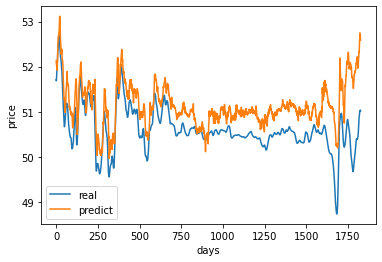

In [12]:
#画图
y=scaler.inverse_transform(testY)
y1=scaler.inverse_transform(testPredict)
plt.plot(y[:,-1],label='real')
plt.plot(y1[:,-1],label='predict')
plt.ylabel('price')
plt.xlabel('days')
plt.legend()
plt.show()

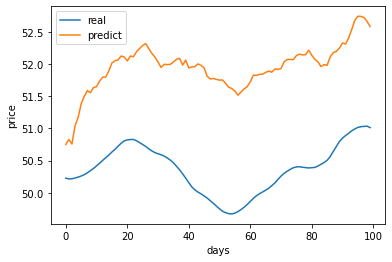

In [13]:
plt.plot(y[-100:,-1],label='real')
plt.plot(y1[-100:,-1],label='predict')
plt.ylabel('price')
plt.xlabel('days')
plt.legend()
plt.show()

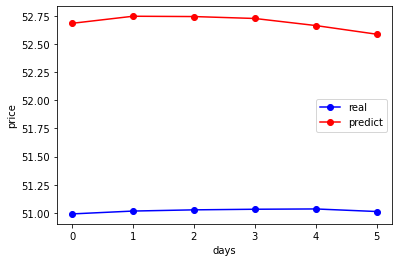

In [14]:
plt.plot(y[-6:,-1],'bo-',label='real')
plt.plot(y1[-6:,-1],'ro-',label='predict')
plt.ylabel('price')
plt.xlabel('days')
plt.legend()
plt.show()